# Probabilistic Graphical Model - Graphs clustering - Visualization Notbook
Allain Louise, Roverato Chiara, Turan Erkan

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from Utils import *
from utils_potts import *
from local_potts import repeated_trials, evaluate_local_potts
from tqdm import tqdm
from benchmark_generation import generate_benchmark
from simulated_annealing import *

## Caveman type graph

### Graph definition

In [2]:
n_clusters = 5
nodes_per_clusters = 20
p_rewiring = 0.2

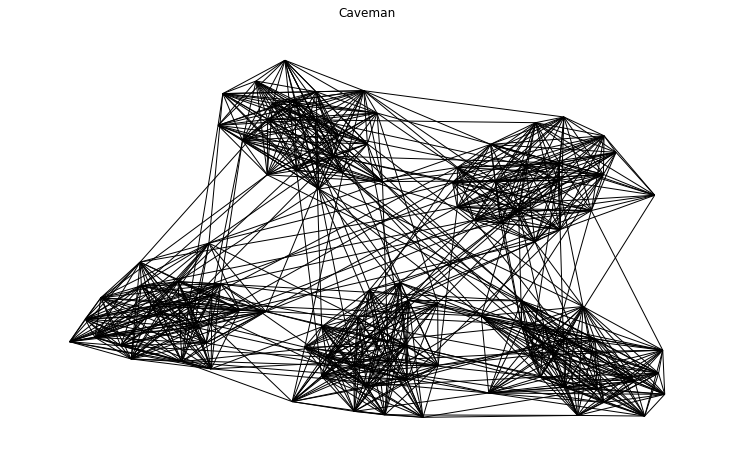

In [4]:
G_caveman = nx.relaxed_caveman_graph(n_clusters, nodes_per_clusters, p_rewiring)
plot_graph_cluster(G_caveman,"Caveman")

### Analysis of the models

In [5]:
# Simulated Annealing for Pott's energy clustering parameters
J = 1
gamma = 0.5
beta_0 = 2
q = 100
eq_steps = 30
mc_steps = 10
alpha = 0.9

# Local Potts parameters
t = 10
gammas = np.linspace(0.1, 2, 10)
gamma_lp = 1

#Modularity parameters
iterations=5
temperature_range = np.arange(3, 7, 1)
cooling_rate_range = np.arange(0.01,0.04,0.01)
optimal_parameters=find_para(G_caveman,n_clusters,temperature_range,cooling_rate_range,iterations,-1)

In [6]:
# Simulated annealing with Pott's energy
G_caveman_initialized = random_initialization(G_caveman, n_clusters)
G_partitionned_sa_potts, B, E, co_matrix_sa_potts = monte_carlo_pott(G_caveman_initialized, J, gamma, beta_0, q, eq_steps, mc_steps, alpha)

# Local Pott's
energies, times = evaluate_local_potts(G_caveman, t, gammas)

#Modularity
para=[(temperature,cooling_rate,final_score) for temperature,cooling_rate,_,final_score,_ in optimal_parameters]
elt= max(range(len(para)), key=lambda i: para[i][2])
temperature,cooling_rate,final_partition,final_score,scores=optimal_parameters[elt]

Annealing step: 0
Annealing step: 1
Annealing step: 2
Annealing step: 3
Annealing step: 4
Annealing step: 5
Annealing step: 6
Annealing step: 7
Annealing step: 8
Annealing step: 9


100%|██████████| 10/10 [05:19<00:00, 32.00s/it]


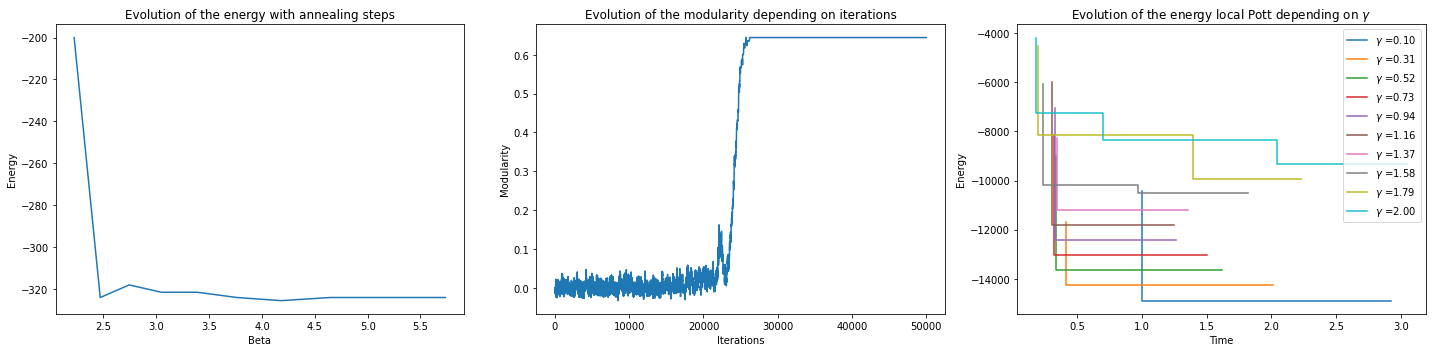

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(B,E)
ax[0].set_title("Evolution of the energy with annealing steps")
ax[0].set_xlabel("Beta")
ax[0].set_ylabel("Energy")

it=np.linspace(0,len(scores),1)
ax[1].plot(scores)
ax[1].set_title("Evolution of the modularity depending on iterations")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Modularity")

for i, (time, energy) in enumerate(zip(times, energies)):
    plt.step(np.cumsum(time[:-1]), energy[:-1], label="$\gamma$ =" + '%.2f' % gammas[i])
ax[2].legend()
ax[2].set_title("Evolution of the energy local Pott depending on $\gamma$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Energy")



plt.tight_layout()
plt.show()

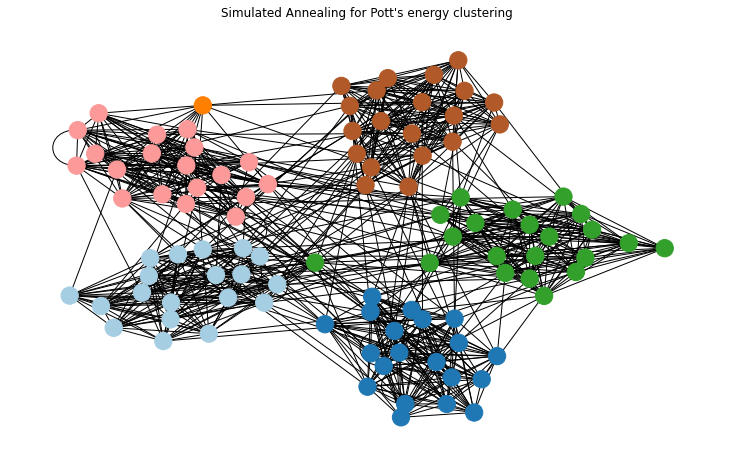

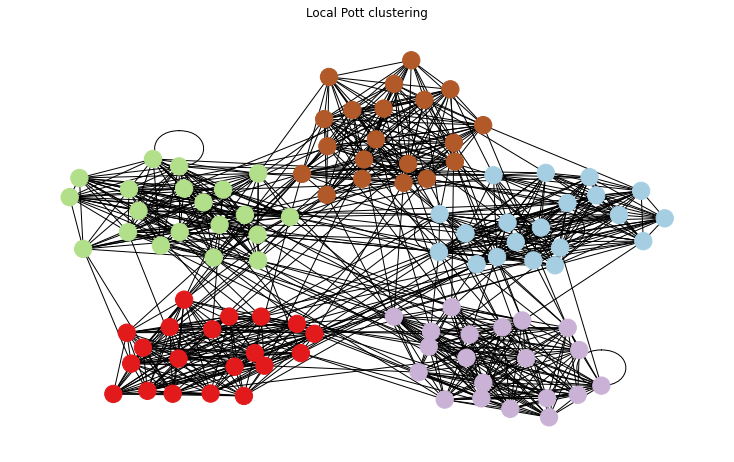

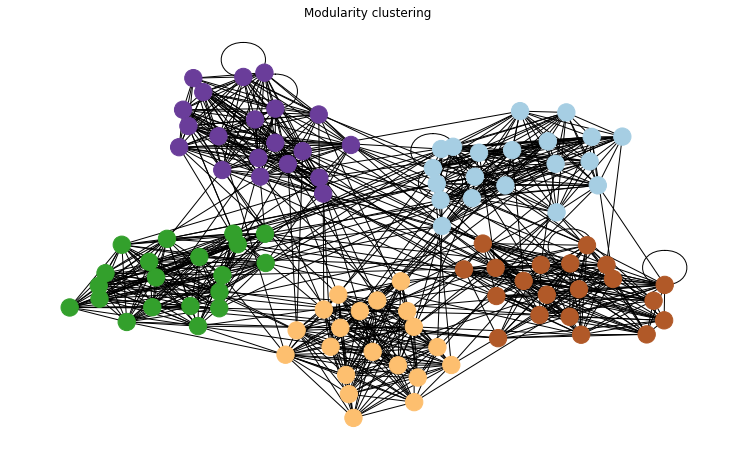

In [41]:
#Pott's
communities_caveman, _, _, _ = repeated_trials(G_caveman, t, gamma=1)
G_caveman_lp = G_caveman.copy()
G_caveman_mod=G_caveman.copy()

#Local Pott's
for node, community in enumerate(communities_caveman):
    G_caveman_lp.nodes[node]['spin'] = community

#Modularity
for node,cluster in final_partition.items():
    G_caveman_mod.nodes[node]['spin'] = cluster

plot_graph_cluster(G_partitionned_sa_potts, title="Simulated Annealing for Pott's energy clustering")
plot_graph_cluster(G_caveman_lp, title="Local Pott clustering")
plot_graph_cluster(G_caveman_mod, title="Modularity clustering")

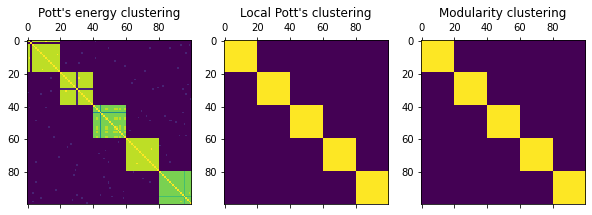

In [45]:
co_matrix_lp = coappearance(G_caveman_lp, np.zeros((G_caveman_lp.number_of_nodes(), G_caveman_lp.number_of_nodes())))
co_matrix_mod = coappearance(G_caveman_mod, np.zeros((G_caveman_mod.number_of_nodes(), G_caveman_mod.number_of_nodes())))

co_matrices = [co_matrix_sa_potts, co_matrix_lp,co_matrix_mod]
models = ["Pott's energy clustering", "Local Pott's clustering","Modularity clustering"]
fig, ax = plt.subplots(1, len(co_matrices), figsize=(10, 10))
for i, (co_matrix, title) in enumerate(zip(co_matrices, models)):
    ax[i].matshow(co_matrix)
    ax[i].set_title(title)

## Naive Graph



### Graph definition

In [5]:
n_nodes = 128
k_clusters = 4
p_in = 0.8
p_out = 0.2

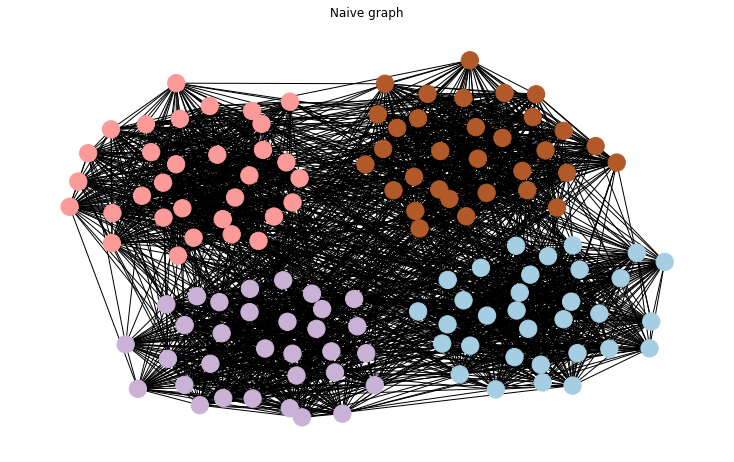

In [6]:
G_naive = generate_known_cluster(n_nodes, k_clusters, p_in, p_out)
M = len(G_naive.edges())
N = len(G_naive.nodes())
p = 2*M/(N*(N-1))
plot_graph_cluster(G_naive,"Naive graph")

### Models analysis

In [7]:
# Simulated Annealing for Pott's energy clustering parameters
J = 1
beta = 10
q = 10
eq_steps = 1
mc_steps = 1
alpha = 0.8
gamma=0.5 #chiara: je l'ai mis moi, erkan tu peux checker?

# Local Potts parameters
t = 10
gammas = np.linspace(0.1, 2, 10)
gamma_lp = 1

#Modularity parameters
iterations=3
temperature_range = np.arange(3, 7, 1)
cooling_rate_range = np.arange(0.01,0.04,0.01)
optimal_parameters=find_para(G_naive,k_clusters,temperature_range,cooling_rate_range,iterations,-1)

Annealing step: 0


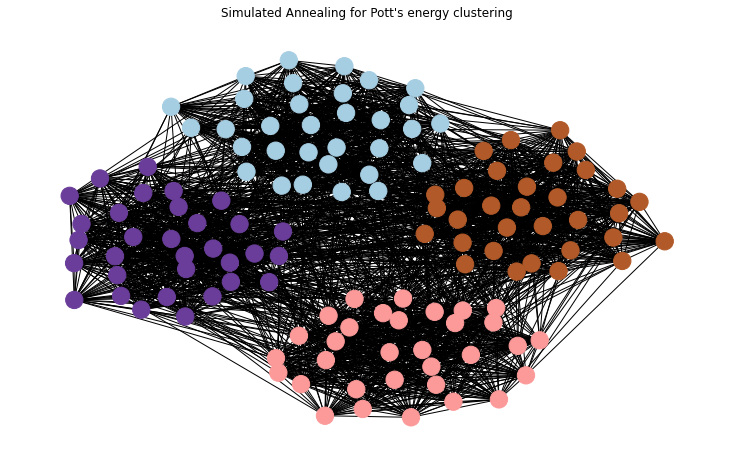

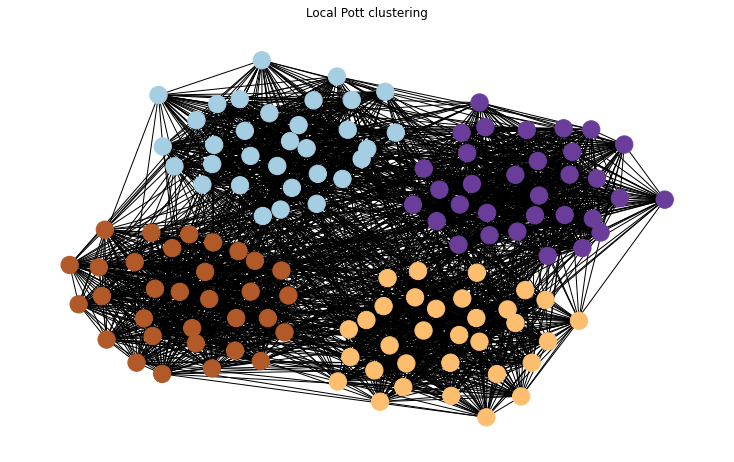

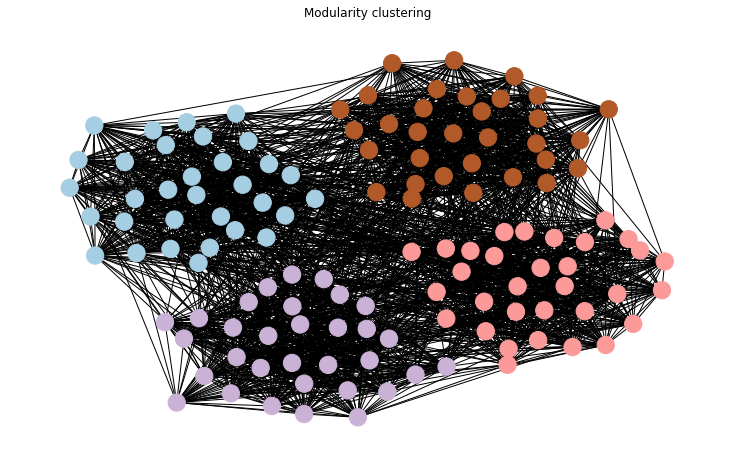

In [14]:
G_naive_sa_potts, _, _, _ = monte_carlo_pott(G_naive, J, gamma, beta, q, eq_steps, mc_steps, alpha)
communities_naive, _, _, _ = repeated_trials(G_naive, t, gamma=1)

G_naive_lp = G_naive.copy()
for node, community in enumerate(communities_naive):
    G_naive_lp.nodes[node]['spin'] = community

G_naive_mod = G_naive.copy()
para=[(temperature,cooling_rate,final_score) for temperature,cooling_rate,_,final_score,_ in optimal_parameters]
elt= max(range(len(para)), key=lambda i: para[i][2])
temperature,cooling_rate,final_partition,final_score,scores=optimal_parameters[elt]
for node,cluster in final_partition.items():
    G_naive_mod.nodes[node]['spin'] = cluster

plot_graph_cluster(G_naive_sa_potts, title="Simulated Annealing for Pott's energy clustering")
plot_graph_cluster(G_naive_lp, title="Local Pott clustering")
plot_graph_cluster(G_naive_mod, title="Modularity clustering")

In [26]:
SPECIFICITY = {0 : {"mean" : [], "std" : []}, 1 : {"mean" : [], "std" : []},2 : {"mean" : [], "std" : []}}
SENSITIVITY = {0 : {"mean" : [], "std" : []}, 1 : {"mean" : [], "std" : []},2 : {"mean" : [], "std" : []}}
P_in = np.linspace(0,1,7)
for p_in in tqdm(P_in):
    p_out = 1-p_in
    G_k_naive = generate_known_cluster(n_nodes,k_clusters,p_in,p_out)
    N_k = len(G_k_naive.nodes())
    M_k = len(G_k_naive.edges())
    p_k = 2*M_k/(N_k*(N_k-1))
    specificity_k = np.empty((3, 3))
    sensitivity_k = np.empty((3, 3))
    for i in range(3):
        G_k_sa_potts,_,_,_ = monte_carlo_pott(G_k_naive, J, p_k, beta, q, eq_steps, mc_steps, alpha)
        communities_k_lp, _, _, _ = repeated_trials(G_k_naive, t, gamma=1)
        final_partition,_,_=simulated_annealing(G_k_naive,k_clusters,temperature,cooling_rate,3)

        G_k_lp = G_k_naive.copy()
        G_k_mod = G_k_naive.copy()

        for node, community in enumerate(communities_k_lp):
            G_k_lp.nodes[node]['spin'] = community

        for node,cluster in final_partition.items():
            G_k_mod.nodes[node]['spin'] = cluster

        specificity_k[0, i] = specificity(G_k_naive, G_k_sa_potts)
        sensitivity_k[0, i] = sensitivity(G_k_naive, G_k_sa_potts)
        specificity_k[1, i] = specificity(G_k_naive, G_k_lp)
        sensitivity_k[1, i] = sensitivity(G_k_naive, G_k_lp)
        specificity_k[2, i] = specificity(G_k_naive, G_k_mod)
        sensitivity_k[2, i] = sensitivity(G_k_naive, G_k_mod)

    for j, (sp, se) in enumerate(zip(specificity_k, sensitivity_k)):
        SPECIFICITY[j]["mean"] += [np.mean(sp)]
        SPECIFICITY[j]["std"] += [np.std(sp)]
        SENSITIVITY[j]["mean"] += [np.mean(se)]
        SENSITIVITY[j]["std"] += [np.std(se)]

  0%|          | 0/7 [00:00<?, ?it/s]

Annealing step: 0
Annealing step: 0
Annealing step: 0


Annealing step: 0
Annealing step: 0
Annealing step: 0


Annealing step: 0
Annealing step: 0
Annealing step: 0


Annealing step: 0


In [ ]:
models = ["Pott's", "Local Pott's","Modularity"]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Specifity and sensitivity depending on intra-cluster connection probability")
ax[0].set_ylabel('Specificity')
ax[1].set_ylabel('Sensitivity')
ax[0].set_xlabel('$p_{in}$')
ax[1].set_xlabel('$p_{in}$')
for i in SENSITIVITY:
    ax[0].scatter(P_in, SPECIFICITY[i]['mean'], label=models[i])
    ax[0].errorbar(P_in, SPECIFICITY[i]['mean'], SPECIFICITY[i]['std'])
    ax[1].scatter(P_in, SENSITIVITY[i]['mean'], label=models[i])
    ax[1].errorbar(P_in, SENSITIVITY[i]['mean'], SENSITIVITY[i]['std'])
    
ax[0].legend()
ax[1].legend()

### Influence of the number of clusters q:

In [ ]:
K = [0.3,0.6,0.9]
means = []
stds = []
for k_in in K:
  mean_q = []
  std_q = []

  k_out = 1-k_in
  ref_k = generate_known_cluster(128,4,k_in,k_out)
  N_k = len(ref_k.nodes())
  M_k = len(ref_k.edges())
  p_k = 2*M_k/(N_k*(N_k-1))
  Q = np.linspace(5,50,7).astype(int)

  for q in Q:
    mean_t = []
    std_t = []
    for t in range(5):
      clustered_graph,_,_,_ = monte_carlo_pott(ref_k, 1, p_k, 10,q,1,1,0.80)
      sen = sensitivity(ref_k, clustered_graph)
      mean_t.append(sen)

    mean_q.append(np.mean(mean_t))
    std_q.append(np.std(mean_t))
  means.append(mean_q)
  stds.append(std_q)

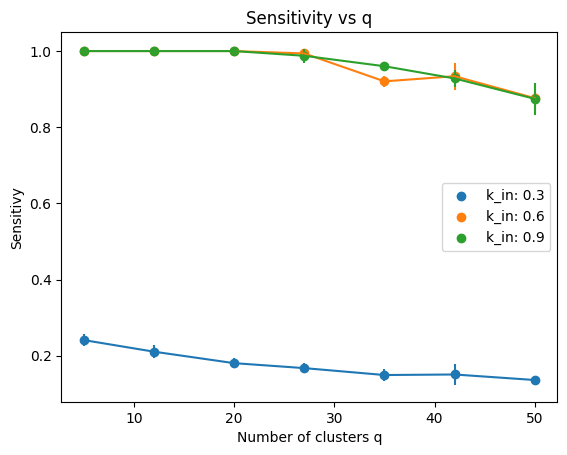

In [ ]:
for i in range(3):
  plt.scatter(Q, means[i], label="k_in: " + str(K[i]))
  plt.errorbar(Q, means[i],stds[i])

plt.title("Sensitivity vs q")
plt.xlabel("Number of clusters q")
plt.ylabel("Sensitivy")
plt.legend()
plt.show()

## Synthetic benchmark

### Graph generation

In [ ]:
N = 500
hkis = np.arange(15, 35, 4)
gammas_bm = [2, 3]
betas_bm = [1, 2]
mus = np.arange(0.4, 1, 0.1)

In [ ]:
n_hkis = len(hkis)
for i, hki in enumerate(hkis):
    print(i+1, "/", len(hkis), ":")
    for gamma_bm, beta_bm in zip(gammas_bm, betas_bm):
            for mu in tqdm(mus):
                save_path = 'benchmark/benchmark_'+str(N)+'_'+str(hki)+'_'+str(gamma_bm)+'_'+str(beta_bm)+'_'+str(mu)
                if not os.path.isfile(save_path+'.gml'):
                    G = generate_benchmark(N, hkis[0], gammas_bm[0], betas_bm[0], mus[-1], save_path=save_path)

In [ ]:
G = nx.read_gml('benchmark/benchmark_100_15_2_1_0.7.gml')
G = nx.convert_node_labels_to_integers(G)

### Models analysis

In [ ]:
# Simulated annealing with Pott's energy
G_initialized = random_initialization(G, k_clusters)
G_partitionned_sa_potts, B, E, co_matrix_sa_potts = monte_carlo_pott(G_initialized, J, gamma, beta, q, eq_steps, mc_steps, alpha)

# Local Pott's
communities, _, _, _ = repeated_trials(G, t, gamma=1)
G_lp = G.copy()
for node, community in enumerate(communities):
    G_lp.nodes[node]['spin'] = community
co_matrix_lp = coappearance(G_lp, np.zeros((G_lp.number_of_nodes(), G_lp.number_of_nodes())))
co_matrices = [co_matrix_sa_potts, co_matrix_lp]
models = ["Simulated Annealing for Pott's energy clustering", "Local Pott's clustering"]
fig, ax = plt.subplots(1, len(co_matrices), figsize=(10, 10))
for i, (co_matrix, title) in enumerate(zip(co_matrices, models)):
    ax[i].matshow(co_matrix)
    ax[i].set_title(title)

In [ ]:
hki = hkis[-1]
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle("Specifity and sensitivity depending on intra-cluster connection probability")

for gamma_bm, beta_bm in zip(gammas_bm, betas_bm):
    SPECIFICITY = {0 : {"mean" : [], "std" : []}, 1 : {"mean" : [], "std" : []}}
    SENSITIVITY = {0 : {"mean" : [], "std" : []}, 1 : {"mean" : [], "std" : []}}
    P_in = np.linspace(0,1,15)
    for mu in tqdm(mus):
        save_path = 'benchmark/benchmark_'+str(N)+'_'+str(hki)+'_'+str(gamma_bm)+'_'+str(beta_bm)+'_'+str(mu)+'.gml'
        G_mu = nx.convert_node_labels_to_integers(nx.read_gml(save_path))
        for node in G_mu.nodes:
            G_mu.nodes[node]["spin"] = G_mu.nodes[node]["community"]
        N_k = len(G_mu.nodes())
        M_k = len(G_mu.edges())
        p_k = 2*M_k/(N_k*(N_k-1))
        specificity_mu = np.empty((2, 5))
        sensitivity_mu = np.empty((2, 5))
        for i in range(5):
            G_mu_initialized = random_initialization(G_mu, k_clusters)
            G_mu_sa_potts,_,_,_ = monte_carlo_pott(G_mu, J, p_k, beta, q, eq_steps, mc_steps, alpha)
            communities_k_lp, _, _, _ = repeated_trials(G_mu, t, gamma=1)
            G_mu_lp = G_mu.copy()
            for node, community in enumerate(communities_k_lp):
                G_mu_lp.nodes[node]['spin'] = community
            specificity_mu[0, i] = specificity(G_mu, G_mu_sa_potts)
            sensitivity_mu[0, i] = sensitivity(G_mu, G_mu_sa_potts)
            specificity_mu[1, i] = specificity(G_mu, G_mu_lp)
            sensitivity_mu[1, i] = sensitivity(G_mu, G_mu_lp)
        for j, (sp, se) in enumerate(zip(specificity_mu, sensitivity_mu)):
            SPECIFICITY[j]["mean"] += [np.mean(sp)]
            SPECIFICITY[j]["std"] += [np.std(sp)]
            SENSITIVITY[j]["mean"] += [np.mean(se)]
            SENSITIVITY[j]["std"] += [np.std(se)]
    models = ["Pott's", "Local Pott's"]
    for i in range(2):
            ax[0][i].set_ylabel('Specificity')
            ax[1][i].set_ylabel('Sensitivity')
            ax[i][0].set_xlabel('$mu$')
            ax[i][1].set_xlabel('$mu$')
            ax[0][i].set_title(models[i])
            ax[1][i].set_title(models[i])
    for i in SENSITIVITY:
        ax[0][i].scatter(mus, SPECIFICITY[i]['mean'], label="$\gamma$="+str(gamma)+", beta="+str(beta))
        ax[0][i].errorbar(mus, SPECIFICITY[i]['mean'], SPECIFICITY[i]['std'])
        ax[1][i].scatter(mus, SENSITIVITY[i]['mean'], label="$\gamma$="+str(gamma)+", beta="+str(beta))
        ax[1][i].errorbar(mus, SENSITIVITY[i]['mean'], SENSITIVITY[i]['std'])
    fig.legend()

## Real Dataset:


### Load dataset

The file football.gml contains the network of American football games
between Division IA colleges during regular season Fall 2000, as compiled
by M. Girvan and M. Newman.  The nodes have values that indicate to which
conferences they belong.  The values are as follows:

  0 = Atlantic Coast
  1 = Big East
  2 = Big Ten
  3 = Big Twelve
  4 = Conference USA
  5 = Independents
  6 = Mid-American
  7 = Mountain West
  8 = Pacific Ten
  9 = Southeastern
 10 = Sun Belt
 11 = Western Athletic

If you make use of these data, please cite M. Girvan and M. E. J. Newman,
Community structure in social and biological networks,
Proc. Natl. Acad. Sci. USA 99, 7821-7826 (2002).

Correction: Two edges were erroneously duplicated in this data set, and
have been removed (21 SEP 2014)

BrighamYoung         12
FloridaState         12
Iowa                 12
KansasState          12
NewMexico            11
TexasTech            12
PennState            12
SouthernCalifornia   12
ArizonaState         11
SanDie

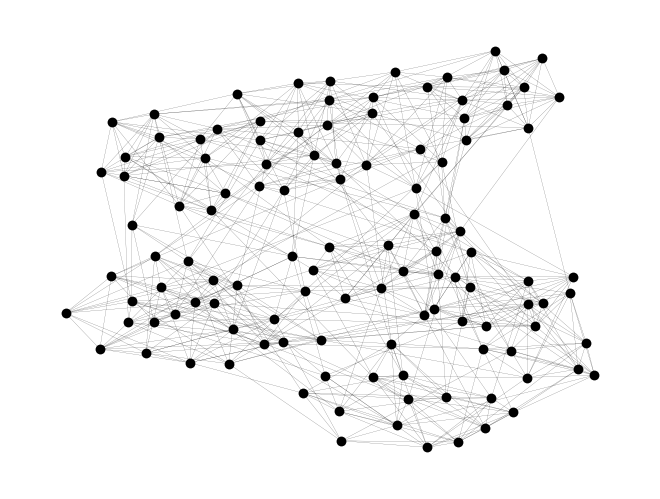

In [ ]:
import urllib.request
import io
import zipfile

import matplotlib.pyplot as plt
import networkx as nx

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G_foot = nx.parse_gml(gml)  # parse gml data

print(txt)
# print degree for each team - number of games
for n, d in G_foot.degree():
    print(f"{n:20} {d:2}")

options = {"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1}

pos = nx.spring_layout(G_foot, seed=1969)  # Seed for reproducible layout
nx.draw(G_foot, pos, **options)
plt.show()

### Models analysis

In [ ]:
G_foot = nx.convert_node_labels_to_integers(G_foot)
init_G_football = random_initialization(G_foot,12)

In [ ]:
# Simulated annealing with Pott's energy
G_foot_partitionned_sa_potts, B, E, co_matrix_sa_potts = monte_carlo_pott(init_G_football, J, gamma, beta, q, eq_steps, mc_steps, alpha)

# Local Pott's
communities, _, _, _ = repeated_trials(G_foot, t, gamma=1)
G_foot_lp = G_foot.copy()
for node, community in enumerate(communities):
    G_foot_lp.nodes[node]['spin'] = community
co_matrix_lp = coappearance(G_foot_lp, np.zeros((G_foot_lp.number_of_nodes(), G_foot_lp.number_of_nodes())))
co_matrices = [co_matrix_sa_potts, co_matrix_lp]
models = ["Simulated Annealing for Pott's energy clustering", "Local Pott's clustering"]
fig, ax = plt.subplots(1, len(co_matrices), figsize=(10, 10))
for i, (co_matrix, title) in enumerate(zip(co_matrices, models)):
    ax[i].matshow(co_matrix)
    ax[i].set_title(title)

In [ ]:
for node in G_foot.nodes:
    G_foot.nodes[node]['spin'] = G_foot.nodes[node]['value']
plot_graph_cluster(G_foot)
plot_graph_cluster(G_foot_partitionned_sa_potts)
plot_graph_cluster(G_foot_lp)

In [ ]:
SPE = []
SEN = []
SPE_std = []
SEN_std = []
for gamma in tqdm(gammas):
    specificity_gamma = []
    sensitivity_gamma = []
    for _ in range(5):
        communities,_,_,_ = repeated_trials(G_foot, t, gamma=gamma)
        G_foot_lp = G_foot.copy()
        for node, community in enumerate(communities):
            G_foot_lp.nodes[node]['spin'] = community
        specificity_gamma.append(specificity(G_foot, G_foot_lp))
        sensitivity_gamma.append(sensitivity(G_foot, G_foot_lp))
    SPE.append(np.mean(specificity_gamma))
    SEN.append(np.mean(sensitivity_gamma))
    SPE_std.append(np.std(specificity_gamma))
    SEN_std.append(np.std(sensitivity_gamma))

## Resolution limit

In [ ]:
G = nx.cycle_graph(10)
nx.draw(G)

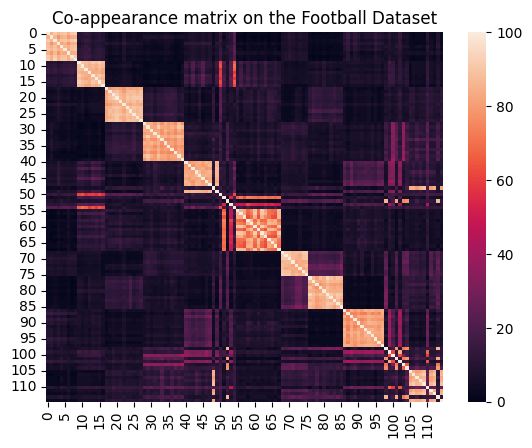

In [ ]:
init_G = random_initialization(G,5)

In [ ]:
# Simulated annealing with Pott's energy
G_partitionned_sa_potts, B, E, co_matrix_sa_potts = monte_carlo_pott(init_G, J, gamma, beta, q, eq_steps, mc_steps, alpha)

# Local Pott's
communities, _, _, _ = repeated_trials(G, t, gamma=1)
G_lp = G.copy()
for node, community in enumerate(communities):
    G_lp.nodes[node]['spin'] = community
co_matrix_lp = coappearance(G_lp, np.zeros((G_lp.number_of_nodes(), G_lp.number_of_nodes())))
co_matrices = [co_matrix_sa_potts, co_matrix_lp]
models = ["Simulated Annealing for Pott's energy clustering", "Local Pott's clustering"]
fig, ax = plt.subplots(1, len(co_matrices), figsize=(10, 10))
for i, (co_matrix, title) in enumerate(zip(co_matrices, models)):
    ax[i].matshow(co_matrix)
    ax[i].set_title(title)

In [ ]:
plot_graph_cluster(G_partitionned_sa_potts, title="Pott's")
plot_graph_cluster(G_lp, title="Local Pott's")